# **LeoVegas Prediction Analysis**
This notebook demonstrates an end-to-end workflow for predicting turnover in a sportsbook dataset.

### Objectives
- Conduct data cleaning and preprocessing.
- Perform exploratory data analysis (EDA).
- Engineer features to enhance predictive power.
- Apply advanced machine learning and time-series models.
- Implement causal inference to derive actionable insights.
- Use conformal predictions for reliable uncertainty estimation.

---

### Prediction target

The prediction target for this task is: total_turn_over_EUR: The total amount of money bet by LeoVegas customers in a given time frame or event.

Why This Target?
Business Relevance:

Total turnover directly reflects customer engagement and revenue generation, making it critical for strategic planning and decision-making.
It enables forecasting for operational scaling, marketing budgets, and identifying high-turnover events.
Stakeholder Impact:

Insights into betting patterns and trends can inform targeted promotions, resource allocation, and risk management.
Predicting turnover provides actionable insights for league-specific marketing and customer segmentation.

#### Workflow to Create a Predictive Model
1. Data Understanding and Exploration
Goals:

Identify patterns, seasonality, and trends in the data.
Understand features influencing turnover, such as time, event, and league.
Actions:

Perform exploratory data analysis (EDA) to uncover trends, anomalies, and correlations.
Visualize turnover against features like hour, day_of_week, league, and event_country.
Tools:

Pandas for data manipulation.
Matplotlib and Seaborn for visualization.

2. Feature Engineering
Purpose:

Create informative features to improve model performance.
Examples:

Time-based features:
Extract hour, day_of_week, month, and is_weekend from bet_placement_hour.
Event-specific features:
Calculate time_to_event (difference between eventStartDate and bet_placement_hour).
Encode event_country and league using target or frequency encoding.
Rolling and lag features:
Add lag_1_turnover and rolling_3_turnover to capture temporal dependencies.


3. Modeling Approach
We will explore two approaches:

Time Series Models:

Use models like SARIMA or Prophet to handle sequential dependencies and seasonal trends.
Ideal for capturing long-term seasonality in turnover.
Machine Learning Models:

Use tree-based models (e.g., LightGBM, XGBoost) for feature-rich tabular data.
Handle non-linear relationships and interactions among features.
AutoML:

Use FLAML or H2O AutoML to automate model selection and hyperparameter tuning.

4. Evaluation
Metrics:

Root Mean Squared Error (RMSE): Measures average prediction error.
Mean Absolute Error (MAE): Measures average absolute error.
R² (Coefficient of Determination): Explains how much variance is captured by the model.
Validation Strategy:

Time-based split: Ensure the training set precedes the test set to mimic real-world scenarios.

5. Uncertainty Quantification
Why?

Provide stakeholders with prediction confidence intervals to aid in risk management.
How?

Use conformal prediction via MAPIE or residual-based methods to quantify prediction uncertainty.

6. Visualization and Reporting
Purpose:

Present results in a stakeholder-friendly manner.
Deliverables:

Line plots of actual vs. predicted turnover.
Confidence intervals to highlight uncertainty.
Feature importance to explain model behavior.

## **1. Import Libraries**

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from dowhy import CausalModel
from mapie.regression import MapieRegressor


## **2. Load and Preprocess Data**

In [49]:
# Load dataset
data = pd.read_csv('../data/dataset.csv')
data

,bet_placement_hour,eventId,eventName,eventStartDate,event_country,league,number_of_bets,total_turn_over_EUR
0,2023-12-01 00:00:00,1020157185,Oklahoma Sooners - Arkansas-Pine Bluff Golden ...,2023-12-01 01:00:00,NCAAB,NaN,3,49.582521
1,2023-12-01 00:00:00,1020211480,LSU Tigers (W) - Virginia Tech Hokies (W),2023-12-01 02:00:00,NCAAW,NaN,4,711.310730
2,2023-12-01 00:00:00,1020030708,Miami Heat - Indiana Pacers,2023-12-01 00:42:54,NBA,NaN,136,5989.053830
3,2023-12-01 00:00:00,1020285783,Union de Mar del Plata - Tomas De Rocamora,2023-12-01 00:00:00,Argentina,TNA,133,1372.405046
4,2023-12-01 00:00:00,1020030708,Miami Heat - Indiana Pacers,2023-12-01 00:30:00,NBA,NaN,25,18843.904216
...,...,...,...,...,...,...,...,...
297282,2024-11-30 23:00:00,1021436280,Utah Jazz - Dallas Mavericks,2024-12-01 02:30:00,NBA,NaN,589,4740.255659
297283,2024-11-30 23:00:00,1021851569,Texas A&M Corpus Christi Islanders - Prairie V...,2024-11-30 21:32:00,NCAAB,NaN,19,284.810951
297284,2024-11-30 23:00:00,1022220957,(6) Houston Cougars - San Diego State Aztecs,2024-12-01 00:06:00,NCAAB,NaN,67,7.021176
297285,2024-11-30 23:00:00,1021703587,Winthrop Eagles (W) - Air Force Falcons (W),2024-11-30 21:30:00,NCAAW,NaN,16,8.907591


In [50]:
print(data.columns)


Index(['bet_placement_hour', 'eventId', 'eventName', 'eventStartDate',
       'event_country', 'league', 'number_of_bets', 'total_turn_over_EUR'],
      dtype='object')


# Which should be target? 
- total_number_over_EUR or number_of_bets?Conformal predicteion
1. Predicting number_of_bets
Why Choose This?
It reflects customer engagement and platform activity, which is critical for marketing, operational planning, and user retention strategies.
Useful for forecasting workload on systems during peak times (e.g., popular games).
Helps identify patterns in betting volume, which can influence promotions and product offerings.
When to Choose This?
If the primary goal is to analyze user behavior and optimize platform performance or engagement strategies.

2. Predicting total_turn_over_EUR
Why Choose This?
It directly ties to revenue and financial metrics.
Helps in assessing risks and profitability by forecasting high-value betting periods.
Useful for managing financial reserves or payouts during peak betting times.
When to Choose This?
If the primary goal is to manage monetary exposure or assess revenue trend

*Recommendation*

Since this is for a sports betting business, and both targets have unique importance, consider the following:

- If the focus is on operational planning and engagement: Use number_of_bets.
- If the focus is on financial management or revenue forecasting: Use total_turn_over_EUR.

In [51]:
# Identify problematic rows
print(data['bet_placement_hour'].head(10))  # Replace with the actual column name


0    2023-12-01 00:00:00
1    2023-12-01 00:00:00
2    2023-12-01 00:00:00
3    2023-12-01 00:00:00
4    2023-12-01 00:00:00
5    2023-12-01 00:00:00
6    2023-12-01 00:00:00
7    2023-12-01 00:00:00
8    2023-12-01 00:00:00
9    2023-12-01 00:00:00
Name: bet_placement_hour, dtype: object


In [52]:
data['bet_placement_hour'] = pd.to_datetime(data['bet_placement_hour'], errors='coerce')
data['eventStartDate'] = pd.to_datetime(data['eventStartDate'], errors='coerce')

# Check for invalid conversions
print(data[data['bet_placement_hour'].isna()])
print(data[data['eventStartDate'].isna()])


Empty DataFrame
Columns: [bet_placement_hour, eventId, eventName, eventStartDate, event_country, league, number_of_bets, total_turn_over_EUR]
Index: []
        bet_placement_hour     eventId  \
17     2023-12-01 00:00:00  1020030708   
27     2023-12-01 00:00:00  1020279406   
31     2023-12-01 00:00:00  1020030714   
36     2023-12-01 00:00:00  1020030711   
40     2023-12-01 00:00:00  1020289801   
...                    ...         ...   
245956 2024-10-08 10:00:00  1020185517   
248021 2024-10-11 13:00:00  1020185517   
248253 2024-10-11 19:00:00  1020185517   
248298 2024-10-11 20:00:00  1020185517   
249957 2024-10-13 18:00:00  1020185517   

                                           eventName eventStartDate  \
17                       Miami Heat - Indiana Pacers            NaT   
27                     Barrio Parque - Gepu San Luis            NaT   
31      Cleveland Cavaliers - Portland Trail Blazers            NaT   
36                 New York Knicks - Detroit Pistons       

In [53]:
# Check and handle invalid eventStartDate entries
data['bet_placement_hour'] = pd.to_datetime(data['bet_placement_hour'], errors='coerce')
data['eventStartDate'] = pd.to_datetime(data['eventStartDate'], errors='coerce')

# Fill missing eventStartDate with bet_placement_hour
data['eventStartDate'] = data['eventStartDate'].fillna(data['bet_placement_hour'])

# Fill missing league values
data['league'] = data['league'].fillna('Unknown')

# Drop any remaining invalid rows
data = data.dropna()

# Verify the processed dataset
print(data.head())
print(data.isna().sum())


  bet_placement_hour     eventId  \
0         2023-12-01  1020157185   
1         2023-12-01  1020211480   
2         2023-12-01  1020030708   
3         2023-12-01  1020285783   
4         2023-12-01  1020030708   

                                           eventName      eventStartDate  \
0  Oklahoma Sooners - Arkansas-Pine Bluff Golden ... 2023-12-01 01:00:00   
1          LSU Tigers (W) - Virginia Tech Hokies (W) 2023-12-01 02:00:00   
2                        Miami Heat - Indiana Pacers 2023-12-01 00:42:54   
3         Union de Mar del Plata - Tomas De Rocamora 2023-12-01 00:00:00   
4                        Miami Heat - Indiana Pacers 2023-12-01 00:30:00   

  event_country   league  number_of_bets  total_turn_over_EUR  
0         NCAAB  Unknown               3            49.582521  
1         NCAAW  Unknown               4           711.310730  
2           NBA  Unknown             136          5989.053830  
3     Argentina      TNA             133          1372.405046  
4     

In [54]:
# Handle outliers
q_low = data['total_turn_over_EUR'].quantile(0.01)
q_high = data['total_turn_over_EUR'].quantile(0.99)
data = data[(data['total_turn_over_EUR'] >= q_low) & (data['total_turn_over_EUR'] <= q_high)]


In [55]:
data

,bet_placement_hour,eventId,eventName,eventStartDate,event_country,league,number_of_bets,total_turn_over_EUR
0,2023-12-01 00:00:00,1020157185,Oklahoma Sooners - Arkansas-Pine Bluff Golden ...,2023-12-01 01:00:00,NCAAB,Unknown,3,49.582521
1,2023-12-01 00:00:00,1020211480,LSU Tigers (W) - Virginia Tech Hokies (W),2023-12-01 02:00:00,NCAAW,Unknown,4,711.310730
2,2023-12-01 00:00:00,1020030708,Miami Heat - Indiana Pacers,2023-12-01 00:42:54,NBA,Unknown,136,5989.053830
3,2023-12-01 00:00:00,1020285783,Union de Mar del Plata - Tomas De Rocamora,2023-12-01 00:00:00,Argentina,TNA,133,1372.405046
4,2023-12-01 00:00:00,1020030708,Miami Heat - Indiana Pacers,2023-12-01 00:30:00,NBA,Unknown,25,18843.904216
...,...,...,...,...,...,...,...,...
297282,2024-11-30 23:00:00,1021436280,Utah Jazz - Dallas Mavericks,2024-12-01 02:30:00,NBA,Unknown,589,4740.255659
297283,2024-11-30 23:00:00,1021851569,Texas A&M Corpus Christi Islanders - Prairie V...,2024-11-30 21:32:00,NCAAB,Unknown,19,284.810951
297284,2024-11-30 23:00:00,1022220957,(6) Houston Cougars - San Diego State Aztecs,2024-12-01 00:06:00,NCAAB,Unknown,67,7.021176
297285,2024-11-30 23:00:00,1021703587,Winthrop Eagles (W) - Air Force Falcons (W),2024-11-30 21:30:00,NCAAW,Unknown,16,8.907591


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291341 entries, 0 to 297286
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   bet_placement_hour   291341 non-null  datetime64[ns]
 1   eventId              291341 non-null  int64         
 2   eventName            291341 non-null  object        
 3   eventStartDate       291341 non-null  datetime64[ns]
 4   event_country        291341 non-null  object        
 5   league               291341 non-null  object        
 6   number_of_bets       291341 non-null  int64         
 7   total_turn_over_EUR  291341 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 20.0+ MB


## **3. Exploratory Data Analysis (EDA)**

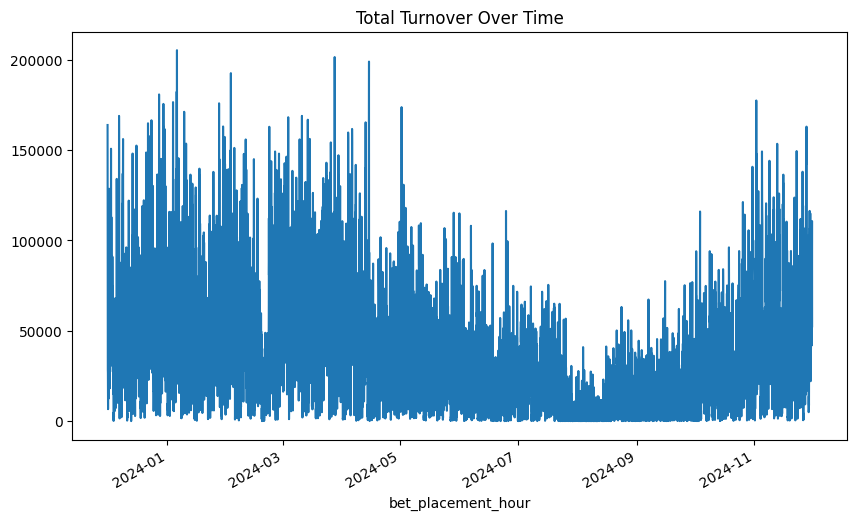

In [57]:
# Time-series visualization
time_series = data.groupby('bet_placement_hour')['total_turn_over_EUR'].sum()
time_series.plot(figsize=(10, 6))
plt.title('Total Turnover Over Time')
plt.show()


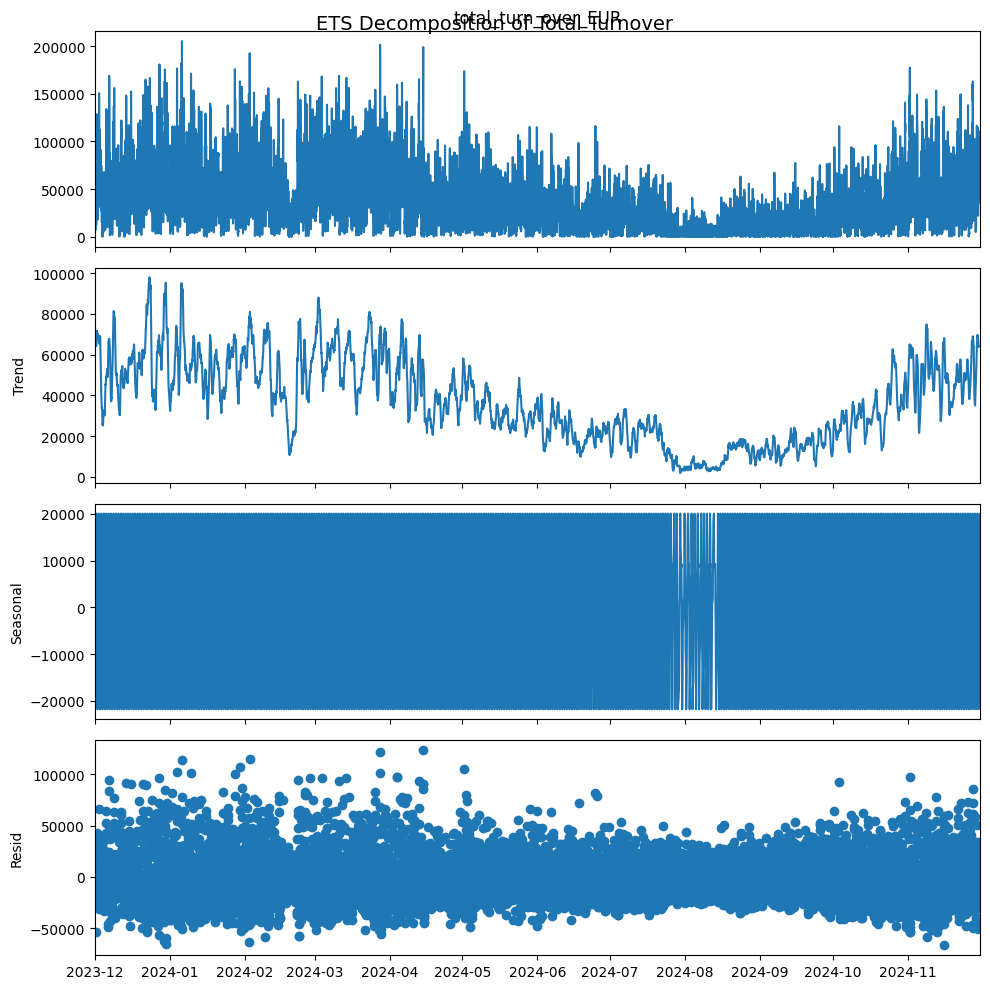

In [58]:
# conduct ETS decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Aggregate total turnover by hour for time-series decomposition
time_series = data.groupby('bet_placement_hour')['total_turn_over_EUR'].sum()

# Perform ETS decomposition
decomposition = seasonal_decompose(time_series, model='additive', period=24)  # Assuming hourly periodicity

# Plot the decomposed components
plt.rcParams.update({'figure.figsize': (10, 10)})
decomposition.plot()
plt.suptitle('ETS Decomposition of Total Turnover', fontsize=14)
plt.show()


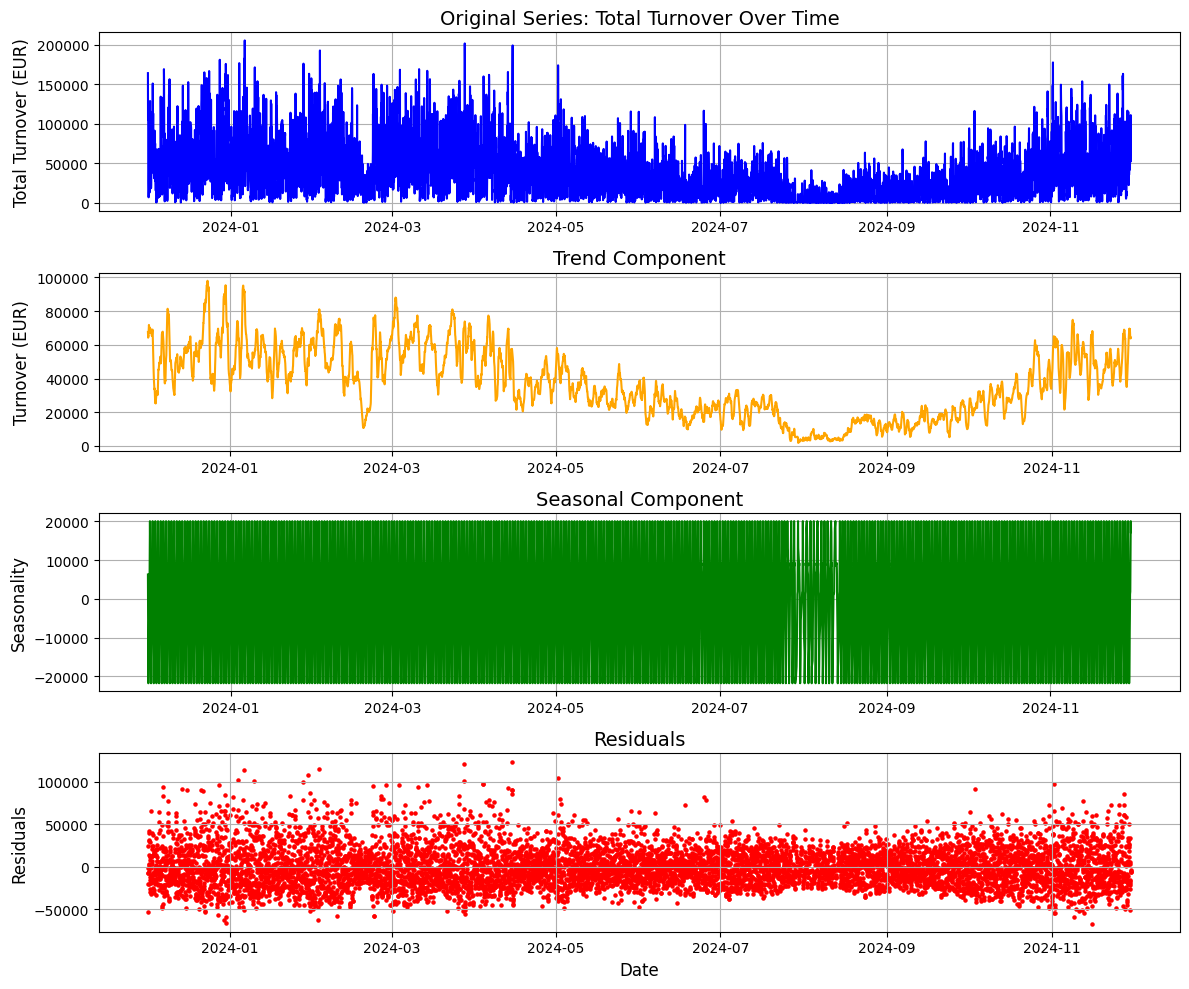

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform ETS decomposition
decomposition = seasonal_decompose(time_series, model='additive', period=24)  # Assuming hourly periodicity

# Plot the decomposed components with improved aesthetics
plt.figure(figsize=(12, 10))

# Original series
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, color='blue')
plt.title('Original Series: Total Turnover Over Time', fontsize=14)
plt.ylabel('Total Turnover (EUR)', fontsize=12)
plt.grid(True)

# Trend component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, color='orange')
plt.title('Trend Component', fontsize=14)
plt.ylabel('Turnover (EUR)', fontsize=12)
plt.grid(True)

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, color='green')
plt.title('Seasonal Component', fontsize=14)
plt.ylabel('Seasonality', fontsize=12)
plt.grid(True)

# Residual component
plt.subplot(4, 1, 4)
plt.scatter(time_series.index, decomposition.resid, color='red', s=5)
plt.title('Residuals', fontsize=14)
plt.ylabel('Residuals', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()


### Explanation of the ETS Decomposition for a Business Decision Maker
The visualization breaks down the total turnover over time into its components: Original Series, Trend, Seasonality, and Residuals. Here's how each component can provide actionable insights for decision-making.
- Trend (T): Determines whether revenue (turnover) is growing, declining, or stable over time.
- Seasonality (S) Helps predict repeated patterns, such as daily or weekly customer behavior.
- Residuals (R): Quantify randomness or noise, highlighting factors not captured by trend or seasonality.
#### 1. Original Series: Total Turnover Over Time
What it shows:

The raw total turnover data across the observed period.
High fluctuations in turnover, with visible peaks and troughs.
Turnover rises significantly toward the end of 2024.
Implications for Business:

High-activity periods: Increased turnover during specific months, such as late 2024, may correspond to important basketball seasons or promotional events.
Volatility management: Large fluctuations indicate the need for dynamic resource allocation (e.g., server capacity, customer support) to handle surges.

#### 2. Trend Component

*What it shows:*

Long-term growth or decline in turnover.
A dip in mid-2024 followed by a strong recovery towards the end of 2024.
Implications for Business:

*Market Analysis:*
The mid-year dip might indicate an off-season or reduced customer engagement.
The end-of-year growth suggests an opportunity to launch targeted promotions or campaigns to capitalize on peak betting activity.
Strategic Planning:
Use the trend data to forecast long-term performance and align marketing strategies with growth phases.

#### 3. Seasonal Component

*What it shows:*

Repeated patterns within the data, likely reflecting periodic betting behavior.
For example, peaks and troughs in the seasonal component might align with daily game schedules or weekly betting trends.

*Implications for Business:*

Customer Behavior:
Predictable seasonal patterns highlight customer engagement linked to events (e.g., evening games or weekend matches).
Targeted Promotions:
Schedule campaigns during high-activity periods to maximize customer engagement and revenue.
Operational Efficiency:
Allocate resources (e.g., marketing budgets or support teams) during high-demand hours or days.

#### 4. Residuals

*What it shows:*

Noise or randomness in the data after removing trend and seasonality.
Large residuals suggest external factors affecting turnover that are not captured by the model.
Implications for Business:

Unexplained Variations:
Investigate large residuals to identify potential drivers, such as unexpected events (e.g., a championship or technical issues).

Model Refinement:
The randomness indicates opportunities for improving predictive models by incorporating more external data (e.g., player stats, event popularity).

*Key Takeaways for Decision-Making*
High-Activity Periods:

Focus efforts during late 2024 to leverage increased customer engagement.
Plan promotional campaigns during periods of seasonal peaks.
Market and Customer Insights:

Use the trend and seasonal data to understand when and why customers engage in betting.
Align marketing strategies to maximize ROI during growth periods.
Operational Adjustments:

Ensure the company’s infrastructure can handle peak loads during high-turnover periods.
Identify and address unexplained residuals to mitigate risks (e.g., unexpected surges or drops in turnover).

*How This Analysis Adds Value*
For a business decision-maker, this decomposition provides a clear breakdown of patterns in customer behavior and operational needs. It ensures decisions are:

Data-Driven: Leverage turnover trends for revenue forecasting and budget planning.
Customer-Centric: Align promotions and resources with periods of high engagement.
Risk-Aware: Proactively address fluctuations and unexplained variations to maintain stable operations.

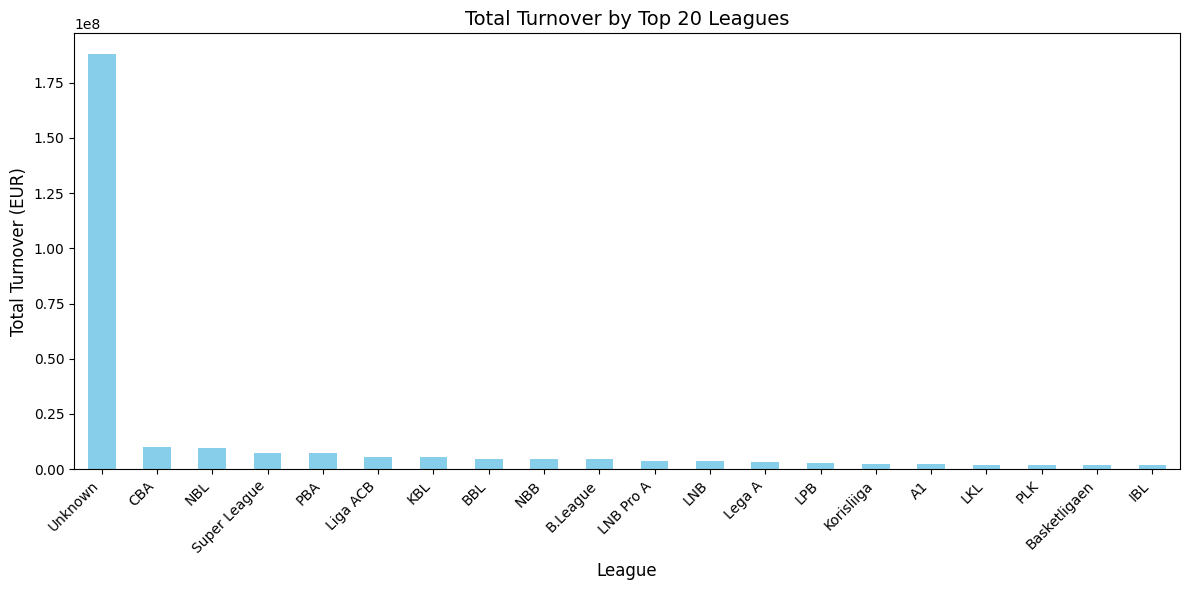

In [60]:
import matplotlib.pyplot as plt

# Aggregate total turnover by league
league_turnover = data.groupby('league')['total_turn_over_EUR'].sum().sort_values(ascending=False)

# Display only the top 20 leagues by total turnover
top_leagues = league_turnover.head(20)

# Plot the total turnover for top leagues
plt.figure(figsize=(12, 6))
top_leagues.plot(kind='bar', color='skyblue')
plt.title('Total Turnover by Top 20 Leagues', fontsize=14)
plt.xlabel('League', fontsize=12)
plt.ylabel('Total Turnover (EUR)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()


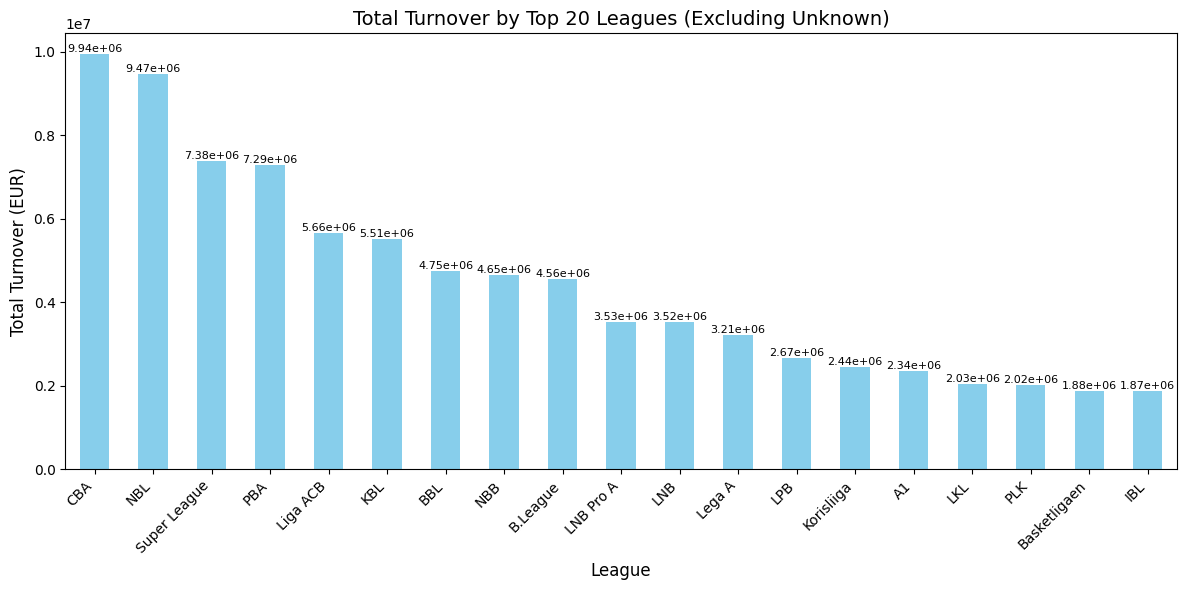

In [61]:
# exclude unknown
# Exclude the 'Unknown' category
top_leagues_no_unknown = top_leagues[top_leagues.index != 'Unknown']

# Plot the total turnover for the top leagues (excluding Unknown)
ax = top_leagues_no_unknown.plot(kind='bar', color='skyblue', figsize=(12, 6))
for i, value in enumerate(top_leagues_no_unknown):
    ax.text(i, value, f'{value:.2e}', ha='center', va='bottom', fontsize=8)

plt.title('Total Turnover by Top 20 Leagues (Excluding Unknown)', fontsize=14)
plt.xlabel('League', fontsize=12)
plt.ylabel('Total Turnover (EUR)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()



### Interpreting the Graph for Business Decision Makers

The graph displays the top 20 leagues (excluding "Unknown") ranked by their total turnover. Turnover here refers to the total amount of money wagered by customers on events in these leagues. Each bar represents the aggregate turnover for a league, giving insights into where the most significant betting activity occurs.

#### Key Observations

*Highest Turnover Leagues:*

- CBA (Chinese Basketball Association) and NBL (National Basketball League) lead in total turnover, indicating they are the most popular leagues among customers.
- These leagues generate nearly €10 million each, representing major revenue streams.

*Long-Tail Distribution:*

The turnover drops significantly after the top 5 leagues (CBA, NBL, Super League, PBA, Liga ACB), highlighting a "long-tail" effect where most revenue comes from a few leagues, while others generate comparatively small amounts.

*Diverse Regional Preferences:* 

- Leagues from different countries (e.g., China, Europe, and the Americas) are represented, suggesting that customer preferences are geographically distributed.
- The presence of leagues like KBL (Korean Basketball League) and BBL (British Basketball League) suggests opportunities to tailor marketing efforts regionally.

### Recommendations for Earning More Revenue
To maximize revenue, focus on the following strategies:

1. Double Down on High-Turnover Leagues
   
Why? The top leagues (e.g., CBA, NBL) already drive the majority of turnover. Enhancing offerings for these leagues can increase engagement and revenue.
How?
Offer specialized promotions or bonuses for popular games in these leagues.
Expand betting options (e.g., prop bets, live betting) to attract more wagers.

3. Target Marketing by Regional Preferences
   
Why? Different leagues appeal to different customer segments based on their location and interests.
How?
Focus marketing campaigns on regions where these leagues are most popular (e.g., promote CBA games in Asian markets).
Use localized advertising during peak game seasons.

5. Explore Growth Opportunities in Mid-Tier Leagues
Why? Mid-tier leagues (e.g., Super League, PBA, Liga ACB) have strong potential for growth as they already have significant turnover but less competition compared to top leagues.
How?
Partner with these leagues to create exclusive promotions.
Invest in educating customers about lesser-known leagues to grow interest and engagement.

7. Seasonal Campaigns
Why? Betting turnover often correlates with league schedules and major events.
How?
Focus promotional campaigns during playoffs, championships, and other high-visibility events for these leagues.
Predict seasonal peaks using historical turnover data to allocate marketing resources effectively.


9. Long-Tail Strategy for Lower-Tier Leagues

    
Why? While smaller leagues (e.g., Basketligan, IBL) contribute less individually, collectively they provide an opportunity to grow aggregate turnover.
How?
Offer niche promotions or bundle smaller leagues with major ones in betting campaigns.
Use targeted incentives like higher odds for these leagues to attract attention.
Operational and Strategic Suggestions
Diversify Betting Options:

Introduce more live betting options for high-turnover leagues like CBA and NBL, which can drive impulsive wagering during games.
Offer specialized bets like player performance or quarter-by-quarter outcomes.
Leverage Customer Data:

Analyze customer preferences for betting patterns in these leagues to personalize promotions.
For example, identify customers who consistently bet on CBA games and offer them loyalty rewards.
Monitor Emerging Trends:

Identify leagues that show consistent growth over time (e.g., mid-tier leagues like Liga ACB or BBL).
Invest in growing these markets through sponsorships or strategic partnerships.
Expand International Presence:

Partner with local broadcasters or sports organizations in regions where these leagues are popular to drive engagement.

*Expected Impact on Revenue*

Enhanced Engagement: By focusing on popular leagues, customer engagement will likely increase, driving higher turnover and subsequent revenue.
Regional Growth: Targeting geographically diverse leagues can help expand the customer base.
New Customer Acquisition: Promoting smaller leagues and offering unique bets can attract new customers and keep existing ones engaged.
By aligning strategies with the insights from this chart, the business can significantly boost both turnover and profitability. Let me know if you'd like a deeper dive into forecasting specific growth opportunities!


## **4. Feature Engineering**

In [62]:
# Add time-based features
data['hour'] = data['bet_placement_hour'].dt.hour
data['day_of_week'] = data['bet_placement_hour'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
data['month'] = data['bet_placement_hour'].dt.month

# Calculate time to event
data['time_to_event'] = (data['eventStartDate'] - data['bet_placement_hour']).dt.total_seconds()

# Add lag and rolling features
data['lag_1_turnover'] = data['total_turn_over_EUR'].shift(1)
data['rolling_3_turnover'] = data['total_turn_over_EUR'].rolling(window=3).mean()
data.dropna(inplace=True)


*Purpose of Feature Engineering in This Context*

The goal of feature engineering in this example is to create new features from the existing data to better capture the relationships and patterns in the dataset. These engineered features help machine learning models and data analysis tools make more accurate predictions or gain deeper insights into customer behavior and betting trends.

*Purpose of Each Feature*

Time-Based Features:

hour: Extracts the hour of the day from the bet_placement_hour column.

Purpose: Captures the time-of-day betting trends. For example, betting might peak during evening games or specific hours.

day_of_week: Extracts the day of the week (e.g., Monday=0, Sunday=6).

Purpose: Identifies day-of-week patterns. For instance, betting might be higher during weekends or weekdays when major games are played.


is_weekend: Encodes whether the day is a weekend (1 for Saturday and Sunday, 0 otherwise).
Purpose: Helps separate weekend-specific betting behavior, which could differ significantly from weekday behavior.

month: Extracts the month of the year.

Purpose: Captures seasonal patterns. Some months may have more betting activity due to playoffs, tournaments, or holidays.

*Event-Based Feature:*

time_to_event: Calculates the time difference (in seconds) between the eventStartDate and the bet_placement_hour.

Purpose: Tracks whether bets are placed early (pre-game) or closer to or during the event (live betting). This can help model different customer behaviors.

*Lag and Rolling Features:*

lag_1_turnover: The total turnover from the previous time step (lag of 1).
Purpose: Captures the immediate past turnover to help models predict current turnover based on recent trends.
rolling_3_turnover: The 3-period rolling average of the total turnover.

Purpose: Smooths out short-term fluctuations and captures broader trends over time, providing a more stable input for predictions.

Drop Missing Values (dropna):

Purpose: Ensures the dataset remains clean by removing rows where lagged or rolling features result in missing values (common at the beginning of time series).

## Conformal prediction with Mapie with one baseline ml model (eg. Random Forest, XGboost)
- there is some issue with XGboost due to memory overload in my laptop used Randomforst as example 
- To conduct conformal prediction using MAPIE with an XGBoost regressor, follow these steps:

*Dataset Preparation:*
- Split the dataset into training, calibration, and test sets.
- Ensure the features and target variables are extracted correctly.

*Model Training:* Train an XGBoost model on the training set.
*Conformal Prediction:*
- Use MAPIE to compute prediction intervals on the calibration set.
- Evaluation: Evaluate the prediction intervals on the test set using metrics like coverage and efficiency.
- Visualize the prediction intervals.


In [63]:
data

,bet_placement_hour,eventId,eventName,eventStartDate,event_country,league,number_of_bets,total_turn_over_EUR,hour,day_of_week,is_weekend,month,time_to_event,lag_1_turnover,rolling_3_turnover
2,2023-12-01 00:00:00,1020030708,Miami Heat - Indiana Pacers,2023-12-01 00:42:54,NBA,Unknown,136,5989.053830,0,4,0,12,2574.0,711.310730,2249.982361
3,2023-12-01 00:00:00,1020285783,Union de Mar del Plata - Tomas De Rocamora,2023-12-01 00:00:00,Argentina,TNA,133,1372.405046,0,4,0,12,0.0,5989.053830,2690.923202
4,2023-12-01 00:00:00,1020030708,Miami Heat - Indiana Pacers,2023-12-01 00:30:00,NBA,Unknown,25,18843.904216,0,4,0,12,1800.0,1372.405046,8735.121031
5,2023-12-01 00:00:00,1020169177,UTSA Roadrunners - Lamar Cardinals,2023-12-01 02:00:00,NCAAB,Unknown,9,0.469974,0,4,0,12,7200.0,18843.904216,6738.926412
6,2023-12-01 00:00:00,1020209529,North Port Batang Pier - Talk 'N Text Tropang ...,2023-12-01 08:00:00,Philippines,PBA,9,0.436083,0,4,0,12,28800.0,0.469974,6281.603424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297282,2024-11-30 23:00:00,1021436280,Utah Jazz - Dallas Mavericks,2024-12-01 02:30:00,NBA,Unknown,589,4740.255659,23,5,1,11,12600.0,41.072563,1596.515710
297283,2024-11-30 23:00:00,1021851569,Texas A&M Corpus Christi Islanders - Prairie V...,2024-11-30 21:32:00,NCAAB,Unknown,19,284.810951,23,5,1,11,-5280.0,4740.255659,1688.713057
297284,2024-11-30 23:00:00,1022220957,(6) Houston Cougars - San Diego State Aztecs,2024-12-01 00:06:00,NCAAB,Unknown,67,7.021176,23,5,1,11,3960.0,284.810951,1677.362595
297285,2024-11-30 23:00:00,1021703587,Winthrop Eagles (W) - Air Force Falcons (W),2024-11-30 21:30:00,NCAAW,Unknown,16,8.907591,23,5,1,11,-5400.0,7.021176,100.246572


In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291339 entries, 2 to 297286
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   bet_placement_hour   291339 non-null  datetime64[ns]
 1   eventId              291339 non-null  int64         
 2   eventName            291339 non-null  object        
 3   eventStartDate       291339 non-null  datetime64[ns]
 4   event_country        291339 non-null  object        
 5   league               291339 non-null  object        
 6   number_of_bets       291339 non-null  int64         
 7   total_turn_over_EUR  291339 non-null  float64       
 8   hour                 291339 non-null  int32         
 9   day_of_week          291339 non-null  int32         
 10  is_weekend           291339 non-null  int64         
 11  month                291339 non-null  int32         
 12  time_to_event        291339 non-null  float64       
 13  lag_1_turnover     

In [65]:
#!pip install --upgrade matplotlib


In [66]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mapie.regression import MapieRegressor
import matplotlib.pyplot as plt

# Assume 'data' is the loaded DataFrame
# Define features and target
features = ['hour', 'day_of_week', 'is_weekend', 'month', 'time_to_event', 'lag_1_turnover', 'rolling_3_turnover']
target = 'total_turn_over_EUR'


In [67]:
# Assume 'X' (features) and 'y' (target) are already prepared and contain all data
X = data[features]
y = data[target]

In [68]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mapie.regression import MapieRegressor
import matplotlib.pyplot as plt

# Ensure target is 1-dimensional
y = y.ravel()  # Flatten y if it's not already 1D

# Split data into Train, Calibration, and Test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_cal, X_test, y_cal, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Reduce calibration and test size if necessary
X_cal = X_cal[:5000]
y_cal = y_cal[:5000]
X_test = X_test[:5000]
y_test = y_test[:5000]

# Train the Random Forest Regressor with fewer estimators
rf_model = RandomForestRegressor(n_estimators=10, max_depth=5, random_state=42, n_jobs=2)

# Apply MAPIE with the "naive" method to reduce memory usage
mapie = MapieRegressor(estimator=rf_model, method="naive", n_jobs=2)
mapie.fit(X_train, y_train)



MapieRegressor(estimator=RandomForestRegressor(max_depth=5, n_estimators=10,
                                               n_jobs=2, random_state=42),
               method='naive', n_jobs=2)

Shape of y_test: (5000,)
Shape of y_pred: (5000,)
Shape of lower_bounds: (5000, 1)
Shape of upper_bounds: (5000, 1)


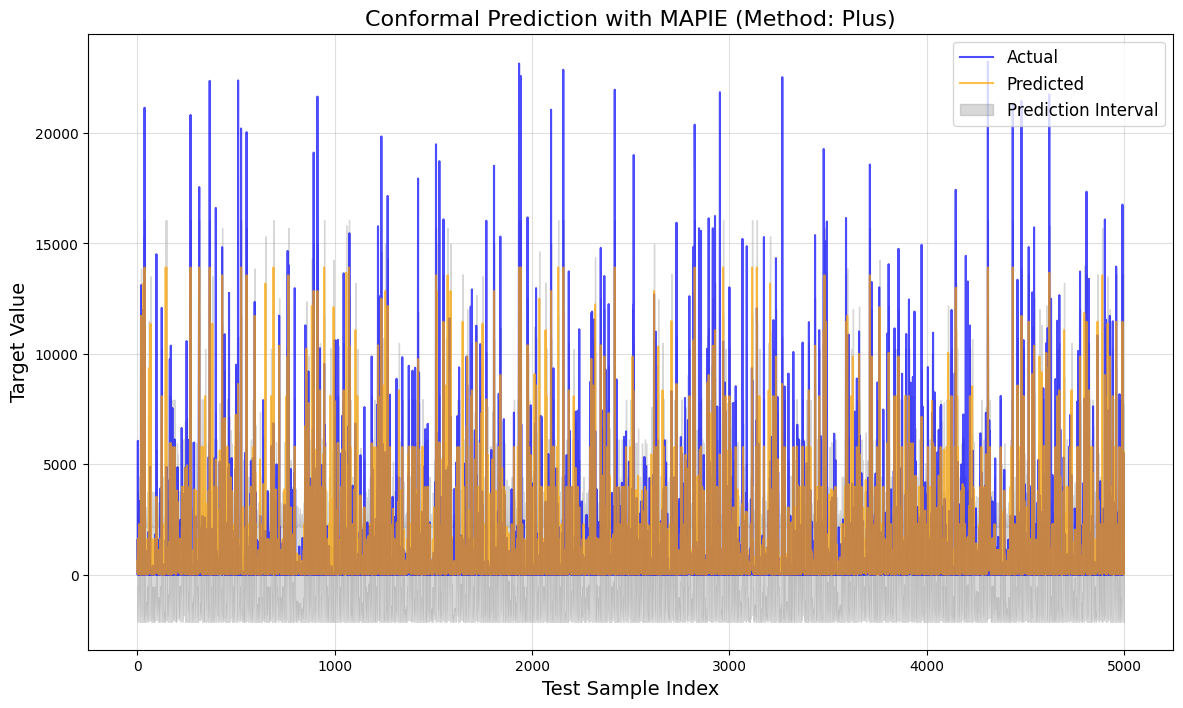

In [69]:
# Generate predictions and prediction intervals
alpha = 0.1  # 90% confidence level
y_pred, y_pred_intervals = mapie.predict(X_test, alpha=alpha)

# Ensure proper dimensions
lower_bounds = y_pred_intervals[:, 0]
upper_bounds = y_pred_intervals[:, 1]

# Debugging: Print shapes
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred:", y_pred.shape)
print("Shape of lower_bounds:", lower_bounds.shape)
print("Shape of upper_bounds:", upper_bounds.shape)

# Flatten arrays if needed
y_test = y_test.ravel()
y_pred = y_pred.ravel()
lower_bounds = lower_bounds.ravel()
upper_bounds = upper_bounds.ravel()

# Visualization
plt.figure(figsize=(14, 8))
plt.plot(range(len(y_test)), y_test, label="Actual", color="blue", alpha=0.7)
plt.plot(range(len(y_test)), y_pred, label="Predicted", color="orange", alpha=0.7)
plt.fill_between(
    range(len(y_test)), lower_bounds, upper_bounds, color="gray", alpha=0.3, label="Prediction Interval"
)
plt.legend(fontsize=12)
plt.xlabel("Test Sample Index", fontsize=14)
plt.ylabel("Target Value", fontsize=14)
plt.title("Conformal Prediction with MAPIE (Method: Plus)", fontsize=16)
plt.grid(alpha=0.4)
plt.show()
